<a href="https://colab.research.google.com/github/TAUforPython/genome-data-PCA/blob/master/PCA_genomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genomic data clustering using Principal Component Analysis (PCA)

## Data
The data for this problem is a real dataset which comes from the [1000 genomes project](https://www.internationalgenome.org/) and the data file is available [here][1].  Each of the 995 lines in the file represents an individual.  The first three columns represent respectively the individual’s unique identifier, his/her sex (1=male, 2=female) and the population he or she belongs to Each of the 995 lines in the file represents an individual. The first threecolumns represent respectively the individual’s unique identifier,  his/her sex (1=male,  2=female) and the population he or she belongs to[^ftnote]. The subsequent 10101 columns of each line are a subsample of nucleobases from the individual’s genome.

**Primer on PCA**

The idea behind PCA is in essence very simple. For a given set of $m$ vectors of the same size (say $n$), or in other words $m$ $n$-dimensional vectors, we are interested in finding $k$ $n$-dimensional vectors where $k \leq m$ that "best" represent the original $m$ $n$-dimensional vectors. In other words, when we approximately express each of the $m$ vectors as a linear combination of the $k$ vetcors, then this is the "best" possible representation of teh vectors. This "best" depends on how we define it. For PCA, the "best" $k$ vectors are those that capture the *maximum variance of data (the $m$ vectors)*. This is also mathematically equivalent to saying (duality) that PCA defines the “best-fit line” (one along each of the $k$ vectors) as the one that minimizes the average squared Euclidean distance between the line and the data points. These top $k$ "best" vectors are what are called the *principal components of the data*. The illustration on the right should help identify what the principal component looks like (adopted from [Gregory Valiant](https://theory.stanford.edu/~valiant/)'s notes)

<img src="{{ "/assets/images/genemirror/PCA.png" | absolute_url }}"
width="50%" hspace="20" align="right">

In the illustration, the "good" line (the first principal component) is the one for which projection of the data points onto it keeps the two clusters separated, while the projection onto the bad line merges the two clusters. The theory for computing involves eigenvector calculation. We will leave that for `sklearn` but if you are keen, I would direct you to the [notes](https://web.stanford.edu/class/cs168/l/l7.pdf) by Greg.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Read in a Pandas Dataframe

In [6]:
def readAndProcessData():
    """
        Function to read the raw text file into a dataframe and keeping the
        population, gender separate from the genetic data

        We also calculate the population mode for each attribute or trait (columns)
        Note that mode is just the most frequently occuring trait

        return: dataframe (df), modal traits (modes), population and gender for each individual row
    """

    df = pd.read_csv('p4dataset2020.txt', header=None, delim_whitespace=True)
    gender = df[1]
    population = df[2]
    print(np.unique(population))

    df.drop(df.columns[[0, 1, 2]],axis=1,inplace=True)
    modes = np.array(df.mode().values[0,:])
    return df, modes, population, gender


In [7]:
df, modes, population, gender = readAndProcessData()

<ipython-input-6-a81eaf7d26cc>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('p4dataset2020.txt', header=None, delim_whitespace=True)


['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']


So there are individuals from 7 populations in our data

## Preprocessing

To understand what makes some population members special, I would like to focus on the mutations in the genomes rather than the genomes themselves. So I first convert the data from the text file of nucleobases to a real-valued matrix (PCA needs a real-valued matrix). Specifically, convert the genetic data into a binary matrix $X$ such that $X_{i,j}= 0$ if the $i^{th}$ individual has column $j$’s mode nucleobase for his or her $j^{th}$ nucleobase, and $X_{i,j}= 1$ otherwise. Note that in this way, all mutations appear as a 1, even if they are different mutations, so if the mode for column $j$ is “G”, then if individual $i$ has an “A”,“T”, or “C”, then $X_{i,j}= 1$.

In [8]:
def convertDfToMatrix(df, mode):
    """
        Create a binary matrix (binarized) representing mutations away from mode
        Each row is for an individual, and each column is a trait

        binarized_{i,j}= 0 if the $i^{th}$ individual has column
        $j$’s mode nucleobase for his or her $j^{th}$ nucleobase,
        and binarized_{i,j}= 1 otherwise
    """

    raw_np = df.to_numpy()
    binarized = np.where(raw_np!=modes, 1, 0)
    return binarized

In [9]:
X = convertDfToMatrix(df, modes)

## Perform PCA

In [11]:
pca = PCA(n_components=3)
pca.fit(X)

#Data points projected along the first, second and the third PC
projectedPrincipal = np.matmul(X, pca.components_[0])
projectedSecondary = np.matmul(X, pca.components_[1])
projectedTertiary = np.matmul(X, pca.components_[2])

# The dimensions of the returned PCA vectors should be the same as that of
# the original data vectors (the rows corresponding to different individuals).

assert(X.shape[0] == projectedPrincipal.shape[0])

In [12]:
print(pca.components_)

[[-0.00788078 -0.00042279 -0.00249645 ...  0.00206099 -0.00020126
   0.01050932]
 [-0.00659904  0.01302463  0.00508844 ...  0.00044841 -0.00027328
   0.00090603]
 [ 0.00368026 -0.00029012  0.00211331 ...  0.00198067  0.00036286
   0.01152675]]


In [13]:
print(pca.explained_variance_)

[13.50107733 11.00012444  8.85881896]


## Population Clusters from Mutations Data

Let's examine the first 2 principal components of X. These components contain lots of information about our data set.  We'll create a scatter plot with each of the 995 rows of $X$ projected onto the first two principal components.  In other words, the horizontal axis is PC1, the vertical axis is PC2, and each individual should be projected onto the subspace spanned by PC1 and PC2.

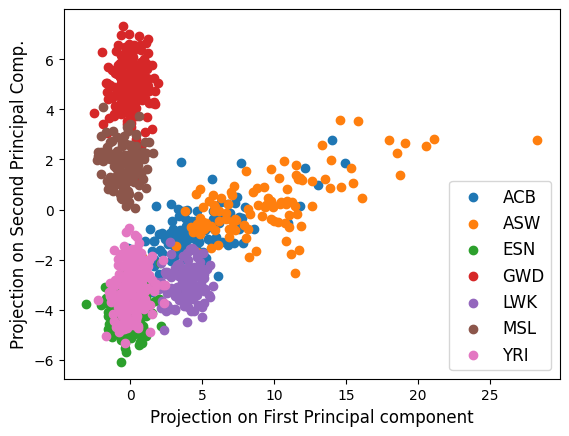

In [14]:
def groupByPop(x, y, classLabels):
    """
        Function that creates a scatter plot of the projections of the
        data points onto the first (principal) PC versus their projection
        on the second PC and labels each datapoint according to which of the
        classes the datapoint belongs to in "classLabels"

        args:
            x: Projection on First Principal component for all datapoints
            y: Projection on Second Principal component for all datapoints
            classLabels: population; can be in ['ACB' 'ASW' 'ESN' 'GWD' 'LWK' 'MSL' 'YRI']
                see http://www.1000genomes.org/faq/which-populations-are-part-your-study/
                for details on population info
    """

    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for lab in classes:
        x, y = classDict[lab]
        plt.scatter(x, y, label=lab)
    plt.legend(fontsize=12)
    plt.xlabel('Projection on First Principal component', fontsize=12)
    plt.ylabel('Projection on Second Principal Comp.', fontsize=12)
    plt.savefig('FirstSecond.png', format='png')
    plt.show()

# call the function
groupByPop(projectedPrincipal, projectedSecondary, population)

**Population clustering!** Notice how different population members have similar values of their projections onto the prncipal components. That means, individuals in a particular population have similar gene mutations such that their data vectors start to look similar! So the correlation between the first and second principal components for members of a population helps cluster the groups! So, it is the first and second PCs that capture varibility in genes due to population differences. Let's keep exploring!

## Gender Clusters from Mutations Data

This time, let's examine the first and the third principal components of X. We'll create a scatter plot with each of the 995 rows of $X$ projected onto the first and third principal components this time.

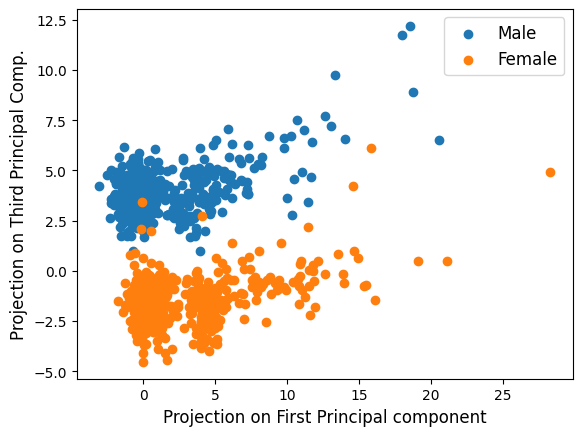

In [15]:
def groupByGender(x, y, classLabels):
    """
        Function that creates a scatter plot of the projections of the
        data points onto the first (principal) PC versus their projection
        on the third PC and labels each datapoint according to which of the
        classes the datapoint belongs to in "classLabels"

        args:
            x: Projection on First Principal component for all datapoints
            y: Projection on Third Principal component for all datapoints
            classLabels: her gender specs of population -- `Male` or `Female`
    """

    classDict = {}
    classes = np.unique(classLabels)
    for label in classes:
        idx = np.where(classLabels == label)
        classDict[label] = (x[idx], y[idx])
    for label in classes:
        x, y = classDict[label]
        plt.scatter(x, y, label='Male' if label == 1 else 'Female')
    plt.legend(fontsize=12)
    plt.xlabel('Projection on First Principal component', fontsize=12)
    plt.ylabel('Projection on Third Principal Comp.', fontsize=12)
    plt.savefig('FirstThird.png', format='png')
    plt.show()

# call the function
groupByGender(projectedPrincipal, projectedTertiary, gender)

Interestingly enough, **gender differences pop out**! Note that there is a strong correlation between data members within the male and within the female sections. Also note once again, the first and third PC projections tend to be different from each other for males and females allowing for clustering!

## Which chromosomes lead to gender differences?

We just remarked above that the third PC is responsible for popping out the gender differences. But can we say more? Can we say which chromosomes are different between males and females? For answering this, we look at the absolute values of the **third principal component** (not the projections) and create a scatter plot between the Nucleobase index and the corresponding third principal component's absolute value.

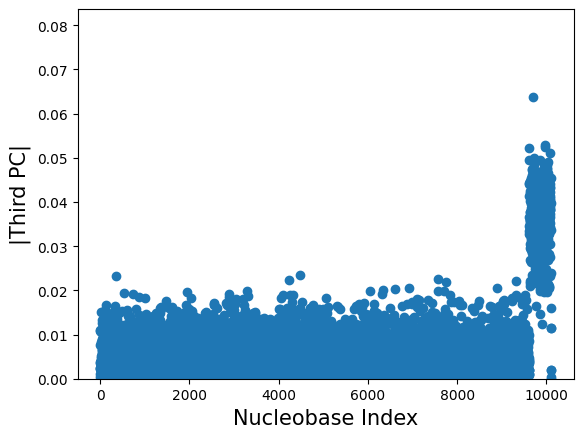

In [16]:
plt.figure()
plt.scatter(np.arange(1,pca.components_[2].shape[0]+1), np.absolute(pca.components_[2]))
plt.xlabel('Nucleobase Index', fontsize=15)
plt.ylabel('|Third PC|', fontsize=15)
plt.savefig('part_f.png', format ='png')
plt.ylim([0, max(np.absolute(pca.components_[2]))+0.02])
plt.show()

We can now say with confidence that the female members and male members must differ in their nucleobases for indices $\sim$9500 and larger. These mutations for index larger than 9500 are responsible then for gender differences.

## Difference between PCA and SVD

Another sister approach of PCA is the popular Singular Value Decomposition ([SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)). SVD is foundational for problems where one attempts to find a good low-rank approximation for a matrix of interest. Often what remains unclear is that the difference between which approach one uses -- PCA or SVD -- depends on what the data is. As a rule of thumb, if you're given a matrix where a row and column position has specific meaning, then we want to go for SVD (such as an image). But if this matrix of interest is an unordered set of vectors, then we go for PCA. For this reason, SVD is often used for image compression, matrix-denoising and matrix-completion applications.

## Conclusions

We have seen that we can cluster the individuals by population and genders. **Takehome message:** Simple techniques can be very useful in discerning important insights! Tools like PCA and SVD are good to have in your repertoire especially when exploring a totally new data you have no clue to to begin with.

Actually the dataset we used is only approximately 0.6% of the original dataset which can be [found here](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/), so you can keep exploring more beyond the African population if you like!

[1]: dsds
[^ftnote]: http://www.1000genomes.org/faq/which-populations-are-part-your-study/